In [1]:
import os, sys
sys.path.append(os.path.expanduser('~/repos/runawaysearch/src'))
from gaiastars import gaiastars as gs
import astropy.units as u

In [2]:
import pandas as pd
df = pd.read_csv('../lists/pleiades-id.csv')
pleiades_members = df.source_id.to_list()
pleiades = gs(name='Pleiades Members', description='from Columbia Paper')
pleiades.from_source_idlist(pleiades_members)

INFO: Query finished. [astroquery.utils.tap.core]


In [3]:
pleiades_biggies_ids = {'Atlas':66526127137440128,
                        'Pleione': 66529975427235712,
                        'Alcyone':66714384142368256,
                        'Merope':65205373152172032,
                        'Electra': 65271996684817280,
                        'Maia':65283232316451328,
                        'Taygeta': 65296907494549120,
                        'Asterope':66798496781121792,
                        'Celaeno':65287458566524928}
idl = [id for id in pleiades_biggies_ids.values()]

pleiades_biggies = gs(name='Big Stars in Pleiades', description='From Wikipedia')
pleiades_biggies.from_source_idlist(idl)

#stuff in missing parallax for Alcyone (source Simbad)
pleiades_biggies.objs.at[66714384142368256,'parallax'] = 8.09
pleiades_biggies.objs.at[66714384142368256,'r_est'] = 1000/8.09

#fix up the names
id_to_name = dict((v,k) for k,v in pleiades_biggies_ids.items())


cols, mags = pleiades_biggies.get_colors()
pleiades_biggies.objs.reset_index(inplace=True)
pleiades_biggies.objs['typed_id']=[id_to_name[t_id] for t_id in pleiades_biggies.objs.typed_id]
pleiades_biggies.objs.set_index('typed_id', inplace=True)
pleiades_biggies.objs

INFO: Query finished. [astroquery.utils.tap.core]


,source_id,ra,dec,parallax,pmra,pmdec,radial_velocity,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,ruwe,r_est
typed_id,,,,,,,,,,,,
Atlas,66526127137440128,57.290689,24.053212,8.118448,19.078968,-46.193245,NaN,3.615795,3.583036,3.619412,4.116527,123.176246
Pleione,66529975427235712,57.296831,24.136498,7.241378,19.496054,-47.649899,NaN,5.203287,5.185276,5.218389,1.303494,138.095257
Alcyone,66714384142368256,56.871251,24.104934,8.090000,NaN,NaN,NaN,2.896132,3.026533,2.878190,NaN,123.609394
Merope,65205373152172032,56.581671,23.948144,7.067029,13.075220,-48.403790,NaN,4.172742,4.148266,4.159457,2.329801,141.502185
Electra,65271996684817280,56.219005,24.113133,8.345685,20.541505,-46.081450,4.795939,3.698209,3.645838,3.733800,2.767541,119.822397
Maia,65283232316451328,56.456796,24.367541,7.671310,19.515752,-45.527310,16.286316,3.863349,3.836872,3.850640,3.542117,130.355833
Taygeta,65296907494549120,56.302163,24.467064,9.544445,16.291673,-47.206094,NaN,4.261022,4.224305,4.331630,2.314559,104.772985
Asterope,66798496781121792,56.477085,24.554305,7.305275,20.331403,-46.022055,11.792832,5.752026,5.729278,5.752268,0.879898,136.887379
Celaeno,65287458566524928,56.200992,24.289268,7.385247,19.849144,-44.965596,16.494202,5.441325,5.419782,5.441004,0.963313,135.405087


In [4]:
idl

[66526127137440128,
 66529975427235712,
 66714384142368256,
 65205373152172032,
 65271996684817280,
 65283232316451328,
 65296907494549120,
 66798496781121792,
 65287458566524928]

In [5]:
import tempfile, os
import numpy as np
import pandas as pd
import pickle

import astropy.units as u
import astropy.coordinates as coord
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.table import Table
from astropy.units import Quantity
from astroquery.gaia import Gaia

In [6]:
def source_id_to_xmlfile(source_idlist, sidcol='typed_id', table_id='source_idlist'):
	#need tempfile for source id list
	fh =  tempfile.mkstemp()
	os.close(fh[0]) #fh[0] is the file descriptor; fh[1] is the path

	#xml-ify the source_idlist to a file
	tbl = Table({sidcol:source_idlist})
	tbl.write(fh[1], table_id=table_id, format='votable', overwrite=True)

	return table_id, fh[1], sidcol

In [7]:
from astropy.table import Table

def gaiadr3toPanStarrs1(source_idlist,nearest=True):
	"""
	returns the panstarrs1 cross matches for the given source_idlist
	"""

	upload_tablename, upload_resource, sidcol = source_id_to_xmlfile(source_idlist)

	query_str = ' '.join([f'SELECT tu.{sidcol}, ps1.*',
				f'from tap_upload.{upload_tablename} tu left join gaiadr3.panstarrs1_best_neighbour ps1',
				f'on tu.{sidcol} = ps1.source_id'])
	try:
		job = Gaia.launch_job_async(query=query_str,
								upload_resource=upload_resource,
								upload_table_name=upload_tablename)
		
		# df = job.get_results().to_pandas()
		tbl = job.get_results()
	finally:
		os.remove(upload_resource)
	
	# if nearest:
	# 	#just return the nearest dr3 source id based on angular distance
	# 	ret_df = df.sort_values(['dr2_source_id','angular_distance']).groupby('dr2_source_id',
	# 				as_index=False).first().set_index(sidcol)
	# else:
	# 	ret_df = df.set_index(sidcol)

	# return ret_df
	tbl.add_index('typed_id')
	return tbl

In [8]:
ps1 = gaiadr3toPanStarrs1(pleiades_members, nearest=False)

INFO: Query finished. [astroquery.utils.tap.core]


In [9]:
ps1

typed_id,source_id,clean_panstarrs1_oid,original_ext_source_id,angular_distance,number_of_neighbours,number_of_mates,xm_flag
,,,,arcsec,,,
int64,int64,int64,int64,float32,int16,int16,int16
63449521800719488,63449521800719488,1429340777,133230557739126875,0.09810061,1,0,40
63502259702709888,--,--,--,--,--,--,--
63507860340462208,63507860340462208,1430551078,133300565929697162,0.124564365,1,0,40
63527827643105408,63527827643105408,1435851030,133610565324584819,0.0039202655,1,0,8
65588484235454592,65588484235454592,1465685844,135360582688022104,0.14747891,1,0,40
65589137070475264,65589137070475264,1467111092,135440583154615177,0.109949335,1,0,40
65603946117575936,65603946117575936,1469373799,135570582568226479,0.1223415,1,0,40
65605354866829184,65605354866829184,1470874261,135660582923743941,0.100668035,1,0,40


In [10]:
# Use the pyvo library as our client to the data service.
import pyvo as vo

# For resolving objects with tools from MAST
from astroquery.mast import Mast

# For handling ordinary astropy Tables in responses
from astropy.table import Table
from matplotlib import pyplot as plt

class PanSTARRS1():
	ps1_collist = ['objID', 'RAMean', 'DecMean', 
				   'nDetections', 'ng', 'nr', 'ni', 'nz', 'ny',
					'gMeanPSFMag', 'rMeanPSFMag', 'iMeanPSFMag',
					'zMeanPSFMag', 'yMeanPSFMag']
	def __init__(self, **kwargs):
		self.name=kwargs.pop('name',None)
		self.description = kwargs.pop('description', None)

		self.coords = None
		self.tap_query_string = None
		self.objs = None

	def from_source_id_list(self, source_idlist, columns=None):
		if columns is not None:
			cols=columns
		else:
			cols = PanSTARRS1.ps1_collist

		#make the query string
		sqlcols = ','.join(cols)
		idlist = ','.join([str(id)for id in source_idlist])
		qrystr = 'SELECT '+sqlcols+' from dbo.MeanObjectView where objID in ('+idlist+')'

		#set up the tap service
		TAP_service = vo.dal.TAPService("https://vao.stsci.edu/PS1DR2/tapservice.aspx")
		#let 'er rip
		job = TAP_service.run_async(qrystr)

		self.objs = job.to_table()
		self.objs.add_index('objID')
		print(f'Query returned {len(self.objs)} records')

	def get_colors(self):

		#color
		R_Z = self.objs['rMeanPSFMag']- self.objs['zMeanPSFMag']
		# misuse of upper case G; we're acutally returning gmag (apparent mag)
		G = self.objs['gMeanPSFMag']
		return R_Z, G
	
	
	def plot_hrdiagram(self, **kwargs):
		ax = kwargs.pop('ax',None)
		title = kwargs.pop('title', 'HR Diagram')
		label = kwargs.pop('label',self.name)
		s = kwargs.pop('s', 1) #default size = 1
		xlim = kwargs.pop('xlim', (-1,5))
		ylim = kwargs.pop('ylim', (-5, 25))

   
		if ax is None:
			yax = plt.subplot(111)
		else:
			yax = ax

		R_Z, G = self.get_colors()

		pcm = yax.scatter(R_Z, G, label=label, s=s, **kwargs)

		yax.set_xlim(xlim)
		yax.set_ylim(ylim)
		if not yax.yaxis_inverted():
			yax.invert_yaxis()


		yax.set_title(title)
		yax.set_ylabel(r'$gMag$')
		yax.set_xlabel(r'$rMag - zMag$')
		if ax is None:
			yax.legend()
			
		return pcm


In [11]:
ps1_idlist = list(ps1['original_ext_source_id'][~ps1['source_id'].mask])
pleiades_ps1 = PanSTARRS1(name='Gaia Cross Match')
pleiades_ps1.from_source_id_list(ps1_idlist)

Query returned 801 records


Text(0.5, 0.98, 'Pleiades Members')

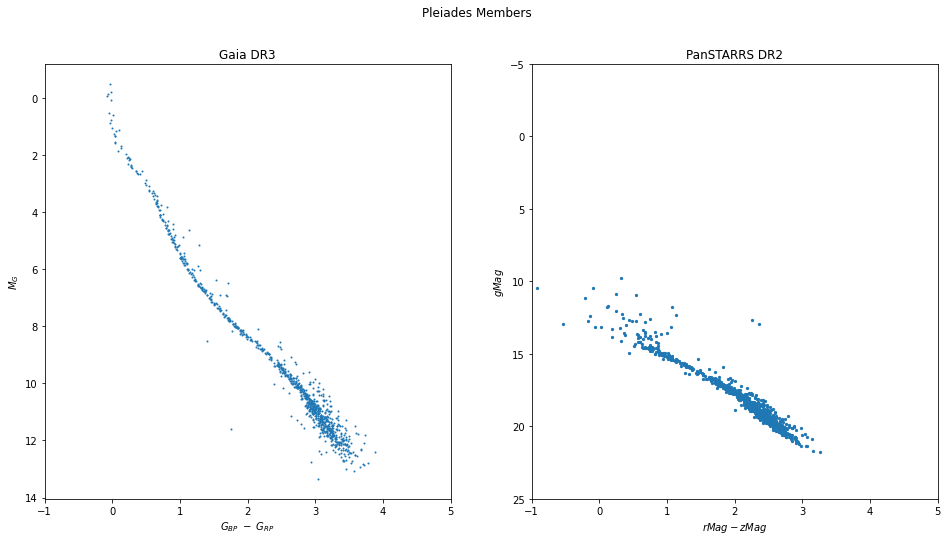

In [12]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121)
pleiades.plot_hrdiagram(ax=ax, title='Gaia DR3')
ax = fig.add_subplot(122)
pleiades_ps1.plot_hrdiagram(ax=ax, s=5, title='PanSTARRS DR2')
fig.suptitle('Pleiades Members')

In [32]:
from astropy.table import Table, join as tbl_join

# fix up the cross match table
xmatch = ps1[['typed_id', 'original_ext_source_id']][~ps1['original_ext_source_id'].mask].copy()
xmatch['typed_id'].name='source_id'
xmatch['original_ext_source_id'].name = 'objID'
xmatch.add_index('objID')

#xmatch.info()

# tack the gaia source id on the panstarrs table
ps1_gaia = tbl_join( pleiades_ps1.objs, xmatch,
                     keys='objID', join_type='left')

# ps1_gaia.info()

#join the ps1 table to the gaia table
pleiades_gaia = tbl_join(Table.from_pandas(pleiades.objs), ps1_gaia,
                     keys='source_id', join_type='left')
pleiades_gaia.add_index('source_id')

In [34]:
pleiades_gaia.iloc[:10]

source_id,ra,dec,parallax,pmra,pmdec,radial_velocity,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,ruwe,r_est,objID,RAMean,DecMean,nDetections,ng,nr,ni,nz,ny,gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,yMeanPSFMag
,,,,,,,,,,,,,deg,deg,,,,,,,mag,mag,mag,mag,mag
int64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float64,int64,float64,float64,int16,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32
51460756250025088,59.271597297744655,20.737765944610018,7.274832361141681,17.870145922256057,-44.36871008373382,--,18.422775,20.46842,17.042345,1.1344302,137.4602121887334,132880592715705904,59.2715795399853,20.7378074768987,80,12,18,20,12,18,21.0679,19.7009,17.7092,16.7609,16.2772
51577476281360512,58.568140253002525,20.92982058927158,6.978239021906169,18.82715305151012,-43.886811533189885,--,17.918812,20.024887,16.592676,1.0380905,143.30262933969277,133110585681416373,58.5681205193187,20.9298664406412,73,10,22,16,11,14,20.3048,19.0146,17.1914,16.3735,15.9576
51616268426009472,58.429315767678595,20.83327996686479,7.435143270986129,19.851565000781413,-45.5223085487388,15.415862,13.973773,14.969579,12.978091,0.979916,134.49639953842734,133000584293180512,58.429296830001,20.8333261211972,61,10,16,14,10,11,15.3941,14.1397,13.461,13.0485,12.8465
51619120284286976,58.370325759330775,20.907165340115196,7.312472679577789,19.218960776558564,-44.584127107508024,-5.815813,11.657691,12.156913,10.985731,1.294968,136.75264767727495,--,--,--,--,--,--,--,--,--,--,--,--,--,--
51694746068624128,59.590166928688234,21.25746893772874,7.336126720514977,17.66425801053892,-44.9401682147099,7.0878253,11.235501,11.664006,10.640917,1.2471755,136.31171299203004,--,--,--,--,--,--,--,--,--,--,--,--,--,--
51760270089541504,59.1615557151752,21.585508415753093,7.050928928167679,18.148940758511863,-44.07519446975317,--,17.056017,18.851414,15.759974,1.0451274,141.82528432602845,133900591615053256,59.1615387751175,21.5855469358086,80,14,22,22,10,12,19.2966,18.0296,16.3279,15.554,15.1755
51765595848971648,59.29092419571437,21.60740677159657,7.206987481677237,18.315870271139914,-43.954755574556856,--,16.671072,18.460726,15.392765,1.0814058,138.7542301887385,133920592908749564,59.2909063056483,21.6074500857922,52,8,14,13,9,8,18.8528,17.5634,15.9659,15.1986,14.8443
53029278307021696,60.358621002820136,21.585596506405725,7.473926226138187,19.10429714130666,-45.854030142547465,--,16.10102,17.739914,14.863558,1.0060776,133.79848418930737,133900603585873336,60.3586025896076,21.585638444113,54,8,15,10,8,13,18.1208,16.8378,15.3799,14.6939,14.3756


(-4.0, 30.0)

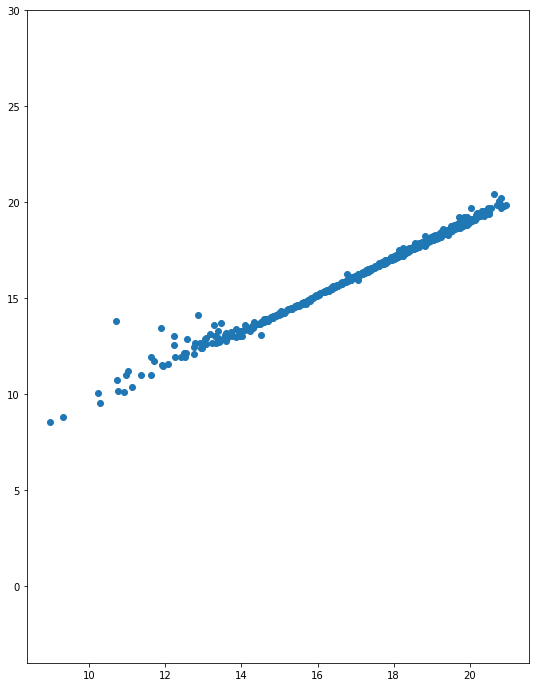

In [35]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(9,12))
ax.scatter(pleiades_gaia['phot_bp_mean_mag'], pleiades_gaia['rMeanPSFMag'] )
ax.set_ylim(-4,30)

In [96]:
ps1[:10]

typed_id,source_id,clean_panstarrs1_oid,original_ext_source_id,angular_distance,number_of_neighbours,number_of_mates,xm_flag
,,,,arcsec,,,
int64,int64,int64,int64,float32,int16,int16,int16
63449521800719488,63449521800719488,1429340777,133230557739126875,0.09810061,1,0,40
63502259702709888,--,--,--,--,--,--,--
63507860340462208,63507860340462208,1430551078,133300565929697162,0.124564365,1,0,40
63527827643105408,63527827643105408,1435851030,133610565324584819,0.0039202655,1,0,8
65588484235454592,65588484235454592,1465685844,135360582688022104,0.14747891,1,0,40
65589137070475264,65589137070475264,1467111092,135440583154615177,0.109949335,1,0,40
65603946117575936,65603946117575936,1469373799,135570582568226479,0.1223415,1,0,40
65605354866829184,65605354866829184,1470874261,135660582923743941,0.100668035,1,0,40


In [63]:
ps1.info()

<Table length=958>
         name           dtype   unit                   description                  n_bad
---------------------- ------- ------ --------------------------------------------- -----
              typed_id   int64                                                          0
             source_id   int64                        Unique Gaia source identifier   157
  clean_panstarrs1_oid   int64                 External Catalogue source identifier   157
original_ext_source_id   int64        Original External Catalogue source identifier   157
      angular_distance float32 arcsec      Angular Distance between the two sources   157
  number_of_neighbours   int16           Number of neighbours in External Catalogue   157
       number_of_mates   int16                    Number of mates in Gaia Catalogue   157
               xm_flag   int16                           Cross-match algorithm flag   157


In [89]:
astropy.table.__version__

NameError: name 'astropy' is not defined

In [66]:
ps1_series = pd.Series(data=ps1['original_ext_source_id'],dtype='jkjkj')

TypeError: data type 'jkjkj' not understood

In [65]:
ps1_series.head()

0    1.332306e+17
1             NaN
2    1.333006e+17
3    1.336106e+17
4    1.353606e+17
dtype: float64

In [14]:
from astropy.io import ascii
ps1[['typed_id','original_ext_source_id']].write('../data/xmatch.csv', overwrite=True, format='csv')

In [15]:
ps1.loc[ps1.original_ext_source_id.notna()]\
    [['source_id','original_ext_source_id']].to_csv('../data/xmatch',index=False)

In [10]:
pleiades.objs.loc[119776604841920896][['ra','dec']]


ra     53.630066
dec    28.841984
Name: 119776604841920896, dtype: float64

In [44]:
from astropy.io import ascii
from astropy.table import Table

import sys
import re
import numpy as np
import matplotlib.pyplot as plt
import json
import requests

try: # Python 3.x
    from urllib.parse import quote as urlencode
    from urllib.request import urlretrieve
except ImportError:  # Python 2.x
    from urllib import pathname2url as urlencode
    from urllib import urlretrieve

try: # Python 3.x
    import http.client as httplib 
except ImportError:  # Python 2.x
    import httplib   

In [40]:
def ps1cone(ra,dec,radius,table="mean",release="dr1",format="csv",columns=None,
           baseurl="https://catalogs.mast.stsci.edu/api/v0.1/panstarrs", verbose=False,
           **kw):
    """Do a cone search of the PS1 catalog
    
    Parameters
    ----------
    ra (float): (degrees) J2000 Right Ascension
    dec (float): (degrees) J2000 Declination
    radius (float): (degrees) Search radius (<= 0.5 degrees)
    table (string): mean, stack, or detection
    release (string): dr1 or dr2
    format: csv, votable, json
    columns: list of column names to include (None means use defaults)
    baseurl: base URL for the request
    verbose: print info about request
    **kw: other parameters (e.g., 'nDetections.min':2)
    """
    
    data = kw.copy()
    data['ra'] = ra
    data['dec'] = dec
    data['radius'] = radius
    return ps1search(table=table,release=release,format=format,columns=columns,
                    baseurl=baseurl, verbose=verbose, **data)


def ps1search(table="mean",release="dr1",format="csv",columns=None,
           baseurl="https://catalogs.mast.stsci.edu/api/v0.1/panstarrs", verbose=False,
           **kw):
    """Do a general search of the PS1 catalog (possibly without ra/dec/radius)
    
    Parameters
    ----------
    table (string): mean, stack, or detection
    release (string): dr1 or dr2
    format: csv, votable, json
    columns: list of column names to include (None means use defaults)
    baseurl: base URL for the request
    verbose: print info about request
    **kw: other parameters (e.g., 'nDetections.min':2).  Note this is required!
    """
    
    data = kw.copy()
    if not data:
        raise ValueError("You must specify some parameters for search")
    checklegal(table,release)
    if format not in ("csv","votable","json"):
        raise ValueError("Bad value for format")
    url = f"{baseurl}/{release}/{table}.{format}"
    if columns:
        # check that column values are legal
        # create a dictionary to speed this up
        dcols = {}
        for col in ps1metadata(table,release)['name']:
            dcols[col.lower()] = 1
        badcols = []
        for col in columns:
            if col.lower().strip() not in dcols:
                badcols.append(col)
        if badcols:
            raise ValueError('Some columns not found in table: {}'.format(', '.join(badcols)))
        # two different ways to specify a list of column values in the API
        # data['columns'] = columns
        data['columns'] = '[{}]'.format(','.join(columns))

# either get or post works
#    r = requests.post(url, data=data)
    r = requests.get(url, params=data)

    if verbose:
        print(r.url)
    r.raise_for_status()
    if format == "json":
        return r.json()
    else:
        return r.text


def checklegal(table,release):
    """Checks if this combination of table and release is acceptable
    
    Raises a VelueError exception if there is problem
    """
    
    releaselist = ("dr1", "dr2")
    if release not in ("dr1","dr2"):
        raise ValueError("Bad value for release (must be one of {})".format(', '.join(releaselist)))
    if release=="dr1":
        tablelist = ("mean", "stack")
    else:
        tablelist = ("mean", "stack", "detection")
    if table not in tablelist:
        raise ValueError("Bad value for table (for {} must be one of {})".format(release, ", ".join(tablelist)))


def ps1metadata(table="mean",release="dr1",
           baseurl="https://catalogs.mast.stsci.edu/api/v0.1/panstarrs"):
    """Return metadata for the specified catalog and table
    
    Parameters
    ----------
    table (string): mean, stack, or detection
    release (string): dr1 or dr2
    baseurl: base URL for the request
    
    Returns an astropy table with columns name, type, description
    """
    
    checklegal(table,release)
    url = f"{baseurl}/{release}/{table}/metadata"
    r = requests.get(url)
    r.raise_for_status()
    v = r.json()
    # convert to astropy table
    tab = Table(rows=[(x['name'],x['type'],x['description']) for x in v],
               names=('name','type','description'))
    return tab


def mastQuery(request):
    """Perform a MAST query.

    Parameters
    ----------
    request (dictionary): The MAST request json object

    Returns head,content where head is the response HTTP headers, and content is the returned data
    """
    
    server='mast.stsci.edu'

    # Grab Python Version 
    version = ".".join(map(str, sys.version_info[:3]))

    # Create Http Header Variables
    headers = {"Content-type": "application/x-www-form-urlencoded",
               "Accept": "text/plain",
               "User-agent":"python-requests/"+version}

    # Encoding the request as a json string
    requestString = json.dumps(request)
    requestString = urlencode(requestString)
    
    # opening the https connection
    conn = httplib.HTTPSConnection(server)

    # Making the query
    conn.request("POST", "/api/v0/invoke", "request="+requestString, headers)

    # Getting the response
    resp = conn.getresponse()
    head = resp.getheaders()
    content = resp.read().decode('utf-8')

    # Close the https connection
    conn.close()

    return head,content


def resolve(name):
    """Get the RA and Dec for an object using the MAST name resolver
    
    Parameters
    ----------
    name (str): Name of object

    Returns RA, Dec tuple with position"""

    resolverRequest = {'service':'Mast.Name.Lookup',
                       'params':{'input':name,
                                 'format':'json'
                                },
                      }
    headers,resolvedObjectString = mastQuery(resolverRequest)
    resolvedObject = json.loads(resolvedObjectString)
    # The resolver returns a variety of information about the resolved object, 
    # however for our purposes all we need are the RA and Dec
    try:
        objRa = resolvedObject['resolvedCoordinate'][0]['ra']
        objDec = resolvedObject['resolvedCoordinate'][0]['decl']
    except IndexError as e:
        raise ValueError("Unknown object '{}'".format(name))
    return (objRa, objDec)


In [41]:
# strip blanks and weed out blank and commented-out values
columns = """objID,raMean,decMean,nDetections,ng,nr,ni,nz,ny,
    gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,yMeanPSFMag""".split(',')
columns = [x.strip() for x in columns]
columns = [x for x in columns if x and not x.startswith('#')]
columns

['objID',
 'raMean',
 'decMean',
 'nDetections',
 'ng',
 'nr',
 'ni',
 'nz',
 'ny',
 'gMeanPSFMag',
 'rMeanPSFMag',
 'iMeanPSFMag',
 'zMeanPSFMag',
 'yMeanPSFMag']

In [45]:
#results1 = ps1search(release='dr2',columns=columns,verbose=True,objid=122851876947049923)
results1 = ps1search(release='dr1',columns=columns,verbose=True, objid=133230557739126875)
tab1 = ascii.read(results1)
# improve the format
for filter in 'grizy':
    col = filter+'MeanPSFMag'
    try:
        tab1[col].format = ".4f"
        tab1[col][tab1[col] == -999.0] = np.nan
    except KeyError:
        print("{} not found".format(col))
tab1

https://catalogs.mast.stsci.edu/api/v0.1/panstarrs/dr1/mean.csv?objid=133230557739126875&columns=%5BobjID%2CraMean%2CdecMean%2CnDetections%2Cng%2Cnr%2Cni%2Cnz%2Cny%2CgMeanPSFMag%2CrMeanPSFMag%2CiMeanPSFMag%2CzMeanPSFMag%2CyMeanPSFMag%5D


objID,raMean,decMean,nDetections,ng,nr,ni,nz,ny,gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,yMeanPSFMag
str18,float64,float64,int32,int32,int32,int32,int32,int32,float64,float64,float64,float64,float64
133230557739126875,55.77397338,21.03023863,80,14,21,16,13,16,19.4169,18.1419,16.4254,15.6324,15.2488


In [15]:
results1 == ''

True

In [16]:
import pandas as pd
pd.DataFrame([[pd.NA]*len(columns)],columns=columns)

,objID,raMean,decMean,nDetections,ng,nr,ni,nz,ny,gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,yMeanPSFMag
0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [49]:
import io
pd.read_csv(io.StringIO(results1))

,objID,raMean,decMean,nDetections,ng,nr,ni,nz,ny,gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,yMeanPSFMag
0,133230557739126875,55.773973,21.030239,80,14,21,16,13,16,19.416901,18.141899,16.4254,15.6324,15.2488


In [47]:
#results1 = ps1search(release='dr2',columns=columns,verbose=True,objid=122851876947049923)
def getPs1Obj(release='dr2', table = 'mean', columns=None, objID=None):
    if objID is None:
        raise ValueError('missing objid')
    res = ps1search(release=release,table=table, columns=columns,objid=objID)
    if res == '':
        #return empty data frame
        ret_df = pd.DataFrame([[pd.NA]*len(columns)],columns=columns)
        if 'objID' in columns:
            ret_df.at[0,'objID'] = objID
    else:
        #return as data frame
        ret_df = pd.read_csv(io.StringIO(res))
    return ret_df
    

In [50]:
getPs1Obj(columns=columns, objID=122851876947049923)

,objID,raMean,decMean,nDetections,ng,nr,ni,nz,ny,gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,yMeanPSFMag
0,122851876947049923,187.694764,12.382818,8,2,1,2,3,0,19.867399,18.592699,19.069201,18.1394,-999.0


In [51]:
getPs1Obj(columns=columns, objID=142610536300511024)

,objID,raMean,decMean,nDetections,ng,nr,ni,nz,ny,gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,yMeanPSFMag
0,142610536300511024,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [52]:
# ps1IDs=ps1.loc[ps1.original_ext_source_id.notna()].original_ext_source_id
ps1IDs = ps1['original_ext_source_id']
ps1IDlist = ps1IDs[~ps1IDs.mask].tolist()

In [53]:
pleiades_ps1 = pd.concat([getPs1Obj(release='dr1',columns=columns, objID=oid)\
                           for oid in ps1IDlist]).reset_index(drop=True)


In [1]:
pleiades_ps1

NameError: name 'pleiades_ps1' is not defined

In [48]:
pleiades_ps1.loc[pleiades_ps1.raMean.notna()]

,objID,raMean,decMean,nDetections,ng,nr,ni,nz,ny,gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,yMeanPSFMag
37,138440539836300224,53.983622,25.366374,69,11,12,15,14,17,16.885599,15.660700,14.495700,13.9269,13.659600
44,134020581903047008,58.190320,21.688705,78,12,20,14,15,17,17.658899,16.389500,15.014100,14.3808,14.081200
59,139260578280185616,57.828015,26.054196,65,10,16,11,14,14,19.115900,17.823799,16.172400,15.4141,15.027100
74,139380536731489520,53.673161,26.157451,63,13,14,16,11,9,20.017401,18.740000,16.920401,16.0786,15.662500
88,139170528110377696,52.811061,25.980916,65,10,18,12,11,14,15.983400,14.733900,13.849900,13.3914,13.158200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779,142240564198912448,56.419920,28.534844,58,9,16,10,10,13,19.633699,18.356501,16.591499,15.7889,15.387200
781,139880576654607200,57.665508,26.572168,57,13,12,8,11,13,18.544201,17.241800,15.831100,15.1454,14.832800
786,139900570519181008,57.051963,26.583618,79,16,16,15,14,18,14.191500,13.024000,12.640000,12.4200,12.298700
791,132880592715705904,59.271590,20.737782,80,12,18,20,12,18,21.067900,19.700899,17.709200,16.7609,16.277201


In [25]:
len(pleiades_ps1), len(pleiades)

(801, 958)

In [32]:
sconstraints = {'primaryDetection':1}

scolumns = """objID,raMean,decMean,nDetections,ng,nr,ni,nz,ny,
    nStackDetections,primaryDetection,
    gPSFMag,rPSFMag,iPSFMag,zPSFMag,yPSFMag""".split(',')
# strip blanks and weed out blank and commented-out values
scolumns = [x.strip() for x in scolumns]
scolumns = [x for x in scolumns if x and not x.startswith('#')]

In [33]:
getPs1Obj(columns=scolumns, table='stack', objID=122851876947049923)

,objID,raMean,decMean,nDetections,ng,nr,ni,nz,ny,nStackDetections,primaryDetection,gPSFMag,rPSFMag,iPSFMag,zPSFMag,yPSFMag
0,122851876947049923,187.69476,12.382815,8,2,1,2,3,0,8,1,19.606199,18.6094,18.643900,18.546101,-999.0000
1,122851876947049923,187.69476,12.382815,8,2,1,2,3,0,8,0,15.715600,-999.0000,18.845301,15.612100,14.5072
2,122851876947049923,187.69476,12.382815,8,2,1,2,3,0,8,0,19.707199,18.7551,15.348000,18.692301,14.3798


In [53]:
getPs1Obj(columns=scolumns, release='dr1', table='stack', objID='139260578280185616&objID=133000584293180512')

HTTPError: 500 Server Error: Internal Server Error for url: https://catalogs.mast.stsci.edu/api/v0.1/panstarrs/dr1/stack.csv?objid=139260578280185616%26objID%3D133000584293180512&columns=%5BobjID%2CraMean%2CdecMean%2CnDetections%2Cng%2Cnr%2Cni%2Cnz%2Cny%2CnStackDetections%2CprimaryDetection%2CgPSFMag%2CrPSFMag%2CiPSFMag%2CzPSFMag%2CyPSFMag%5D

In [44]:
pleiades_ps1_stack = pd.concat([getPs1Obj(release='dr1',columns=scolumns, table='stack', objID=oid)\
                           for oid in ps1IDs]).reset_index(drop=True)

In [49]:
pleiades_ps1.query('objID == 139260578280185616')

,objID,raMean,decMean,nDetections,ng,nr,ni,nz,ny,gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,yMeanPSFMag
59,139260578280185616,57.828015,26.054196,65,10,16,11,14,14,19.1159,17.823799,16.1724,15.4141,15.0271


In [50]:
pleiades_ps1_stack.query('objID == 139260578280185616')

,objID,raMean,decMean,nDetections,ng,nr,ni,nz,ny,nStackDetections,primaryDetection,gPSFMag,rPSFMag,iPSFMag,zPSFMag,yPSFMag
59,139260578280185616,57.828006,26.054201,65,10,16,11,14,14,5,1,19.0802,17.8083,16.1607,15.4191,15.0383


In [46]:
pleiades_ps1_stack.loc[pleiades_ps1_stack.nDetections.notna()]

,objID,raMean,decMean,nDetections,ng,nr,ni,nz,ny,nStackDetections,primaryDetection,gPSFMag,rPSFMag,iPSFMag,zPSFMag,yPSFMag
37,138440539836300224,53.983626,25.366410,69,11,12,15,14,17,5,1,16.896500,15.625800,14.500100,13.960000,13.6809
44,134020581903047008,58.190299,21.688732,78,12,20,14,15,17,5,1,17.692101,16.417999,15.153500,14.402900,14.0697
59,139260578280185616,57.828006,26.054201,65,10,16,11,14,14,5,1,19.080200,17.808300,16.160700,15.419100,15.0383
74,139380536731489520,53.673141,26.157496,63,13,14,16,11,9,5,1,20.026300,18.737200,16.935301,16.064199,15.8385
88,139170528110377696,52.811022,25.980966,65,10,18,12,11,14,5,1,15.965800,14.729500,14.005700,13.430500,13.1951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
791,142240564198912448,56.419877,28.534882,58,9,16,10,10,13,5,1,19.618299,18.362301,16.594801,15.737700,15.4098
793,139880576654607200,57.665455,26.572202,57,13,12,8,11,13,5,1,18.629299,17.241400,15.782000,15.149500,14.7631
798,139900570519181008,57.051937,26.583668,79,16,16,15,14,18,5,1,14.129300,13.936300,13.068600,12.729500,12.5700
803,132880592715705904,59.271565,20.737828,80,12,18,20,12,18,5,1,21.146700,19.722799,17.725201,16.765200,16.2875


In [54]:
from astroquery.mast import Catalogs

In [55]:
catalog_data = Catalogs.query_criteria(coordinates="5.97754 32.53617", radius=0.01,
                                       catalog="PANSTARRS", table="mean", data_release="dr2",
                                       nStackDetections=[("gte", 2)],
                                       columns=["objName", "objID", "nStackDetections", "distance"],
                                       sort_by=[("desc", "distance")], pagesize=15)

HTTPError: 422 Client Error: Unprocessable Entity for url: https://catalogs.mast.stsci.edu/api/v0.1/panstarrs/dr2/mean.json

In [58]:
catalog_data = Catalogs.query_criteria( \
                                       catalog="PANSTARRS", table="mean", data_release="dr1",
                                       objID = [138440539836300224],
                                       columns=["objName", "objID", "nStackDetections", "distance"],
                                       sort_by=[("desc", "distance")], pagesize=15)

HTTPError: 422 Client Error: Unprocessable Entity for url: https://catalogs.mast.stsci.edu/api/v0.1/panstarrs/dr1/mean.json

In [59]:
catalog_data = Catalogs.query_region("158.47924 -7.30962", radius=0.1,
                                      catalog="Panstarrs", data_release="dr1", table="mean")

KeyError: 0

In [60]:
from astroquery.mast import Observations

obs_table = Observations.query_region("322.49324 12.16683")
print(obs_table[:10])

intentType obs_collection provenance_name ... srcDen  obsid        distance     
---------- -------------- --------------- ... ------ -------- ------------------
   science           TESS            SPOC ...    nan 95133321                0.0
   science           TESS            SPOC ...    nan 93770500                0.0
   science           TESS            SPOC ...    nan 93770499 397.01844231118105
   science          SWIFT              -- ... 5885.0  1455548                0.0
   science          SWIFT              -- ... 5885.0  1455549                0.0
   science          SWIFT              -- ... 5885.0  1514187                0.0
   science          SWIFT              -- ... 5885.0  1455550                0.0
   science          SWIFT              -- ... 5885.0  1515379                0.0
   science          SWIFT              -- ... 5885.0  1515380                0.0
   science          SWIFT              -- ... 5885.0  1453534                0.0


In [62]:
np.unique(obs_table['obs_collection'])

EUVE
FUSE
GALEX
HLA
HLSP
HST
IUE
OPO
PS1
SPITZER_SHA
SWIFT


In [63]:
obs_table[obs_table['obs_collection']=='PS1']

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,distance
str11,str11,str31,str13,str12,str27,str16,str33,str40,str92,float64,float64,str10,str25,int64,float64,float64,float64,float64,float64,str106,float64,str20,str12,int64,str25102,str185,str186,str6,bool,float64,str9,float64
science,PS1,3PI,GPC1,PS1,g,OPTICAL,1669.006,--,rings.v3.skycell.1669.006.stk.g,322.56805681096375,12.195673489753212,image,--,3,55416.4871683,56540.32288628516,903.0,394299987792.96875,559299987792.9688,PS1 3PI Survey,57741.5416666,--,3PI,--,POLYGON ICRS 322.790029 11.979144 322.789294 12.413006 322.345669 12.412008 322.347235 11.978182,http://ps1images.stsci.edu/cgi-bin/fitscut.cgi?red=rings.v3.skycell/1669/006/rings.v3.skycell.1669.006.stk.g.unconv.fits,http://ps1images.stsci.edu/rings.v3.skycell/1669/006/rings.v3.skycell.1669.006.stk.g.unconv.fits,PUBLIC,--,5885.0,2275232,0.0
science,PS1,3PI,GPC1,PS1,i,OPTICAL,1669.006,--,rings.v3.skycell.1669.006.stk.i,322.56805681096375,12.195673489753212,image,--,3,55408.5279434,56849.48553513336,1395.0,677799987792.9688,830400024414.0625,PS1 3PI Survey,57741.5416666,--,3PI,--,POLYGON ICRS 322.790029 11.979144 322.789294 12.413006 322.345669 12.412008 322.347235 11.978182,http://ps1images.stsci.edu/cgi-bin/fitscut.cgi?red=rings.v3.skycell/1669/006/rings.v3.skycell.1669.006.stk.i.unconv.fits,http://ps1images.stsci.edu/rings.v3.skycell/1669/006/rings.v3.skycell.1669.006.stk.i.unconv.fits,PUBLIC,--,5885.0,2275233,0.0
science,PS1,3PI,GPC1,PS1,r,OPTICAL,1669.006,--,rings.v3.skycell.1669.006.stk.r,322.56805681096375,12.195673489753212,image,--,3,55412.5681215,56549.26719616295,920.0,538599975585.9375,703599975585.9375,PS1 3PI Survey,57741.5416666,--,3PI,--,POLYGON ICRS 322.790029 11.979144 322.789294 12.413006 322.345669 12.412008 322.347235 11.978182,http://ps1images.stsci.edu/cgi-bin/fitscut.cgi?red=rings.v3.skycell/1669/006/rings.v3.skycell.1669.006.stk.r.unconv.fits,http://ps1images.stsci.edu/rings.v3.skycell/1669/006/rings.v3.skycell.1669.006.stk.r.unconv.fits,PUBLIC,--,5885.0,2275234,0.0
science,PS1,3PI,GPC1,PS1,y,OPTICAL;INFRARED,1669.006,--,rings.v3.skycell.1669.006.stk.y,322.56805681096375,12.195673489753212,image,--,3,55344.5899956,56795.62510062223,1000.0,910000000000.0,1083800048828.125,PS1 3PI Survey,57741.5416666,--,3PI,--,POLYGON ICRS 322.790029 11.979144 322.789294 12.413006 322.345669 12.412008 322.347235 11.978182,http://ps1images.stsci.edu/cgi-bin/fitscut.cgi?red=rings.v3.skycell/1669/006/rings.v3.skycell.1669.006.stk.y.unconv.fits,http://ps1images.stsci.edu/rings.v3.skycell/1669/006/rings.v3.skycell.1669.006.stk.y.unconv.fits,PUBLIC,--,5885.0,2275235,0.0
science,PS1,3PI,GPC1,PS1,z,OPTICAL,1669.006,--,rings.v3.skycell.1669.006.stk.z,322.56805681096375,12.195673489753212,image,--,3,55371.4851426,56793.61457662223,900.0,802799987792.9688,934599975585.9375,PS1 3PI Survey,57741.5416666,--,3PI,--,POLYGON ICRS 322.790029 11.979144 322.789294 12.413006 322.345669 12.412008 322.347235 11.978182,http://ps1images.stsci.edu/cgi-bin/fitscut.cgi?red=rings.v3.skycell/1669/006/rings.v3.skycell.1669.006.stk.z.unconv.fits,http://ps1images.stsci.edu/rings.v3.skycell/1669/006/rings.v3.skycell.1669.006.stk.z.unconv.fits,PUBLIC,--,5885.0,2275236,0.0
science,PS1,3PI,GPC1,PS1,g,OPTICAL,1669.007,--,rings.v3.skycell.1669.007.stk.g,322.15897210178605,12.194466696462094,image,--,3,55416.4931136,56540.32224778517,817.0,394299987792.96875,559299987792.9688,PS1 3PI Survey,57741.5416666,--,3PI,--,POLYGON ICRS 322.381283 11.978280 322.379780 12.412110 321.936246 12.410446 321.938579 11.976677,http://ps1images.stsci.edu/cgi-bin/fitscut.cgi?red=rings.v3.skycell/1669/007/rings.v3.skycell.1669.007.stk.g.unconv.fits,http://ps1images.stsci.edu/rings.